## Visualize trained models

This notebook helps visualize the training progress as well as the resulting model

#### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import IPython
from IPython.display import display, HTML

from State_Generator import Generator
from Model import Complex_CA

#### Load model and data

In [6]:
batch_size = 16
#device = torch.device('mps:0' if torch.backends.mps.is_available else 'cpu')
device = torch.device('cpu')
model = Complex_CA(device, batch_size)


#model.load_state_dict(torch.load('models/complex_ca_stationary.pth'))
#model.load_state_dict(torch.load('models/complex_ca_moving_best1.pth'))
#model.load_state_dict(torch.load('models/complex_ca_moving_temp29.pth', map_location=torch.device('cpu')))

#model.load_state_dict(torch.load('models/complex_ca_moving_temp49.pth'))
#model.load_state_dict(torch.load('models/complex_ca_moving_temp31.pth'))
model.load_state_dict(torch.load('models/complex_ca_moving1_temp23.pth', map_location=device))
#model.load_state_dict(torch.load('models/complex_ca5.pth'))

model = model.to(device)
losses = np.load('losses.npy')
#device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
generator = Generator(device, False)

#### Visualize loss during training

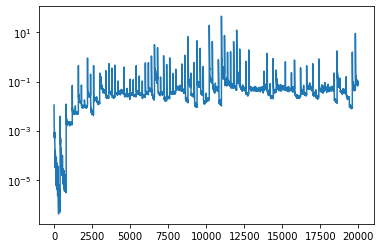

In [3]:
#fig, axes = plt.subplots()
plt.plot(losses)
plt.yscale('log')
plt.show()


#### Visualize CA - Animate

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

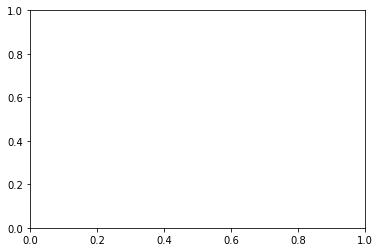

In [4]:
#state = generator.generate_stationary_state(batch_size)
state = generator.generate_moving_state(1, batch_size)

def extract_data(state):
    return state.x.detach().cpu().numpy()[0,0]

@torch.no_grad()
def animate(i):
    global state
    x, food, live_count = model(state.x, state.food, 1)
    state.x = x
    state.food = food
    mat.set_data(extract_data(state)) 

fig, ax = plt.subplots()
mat = ax.matshow(extract_data(state), cmap='gray')

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=50, interval=100).to_jshtml())

#### Visualize Target data:

In [ ]:
#use generator to test generate_moving_state
generator = Generator(device, False)
state = generator.get_centered_CA(batch_size)
#food = generator.random_food_noncentered()
food = generator.random_food(batch_size)

@torch.no_grad()
def animate(i):
    global state
    #generator.generate_moving_state(100)
    state = generator.move_towards_food(state, food)
    mat.set_data(state[0])

fig, ax = plt.subplots()
mat = ax.matshow(state[0], cmap='gray')

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=50, interval=100).to_jshtml())

#### Combined simulation and CA movement

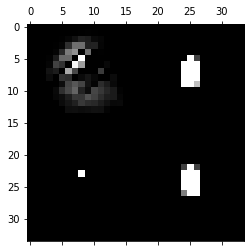

In [11]:
#state = generator.generate_stationary_state(batch_size)
state = generator.generate_moving_state(50, batch_size)

def extract_data(cell, target):
    row1 = np.hstack((cell[0, 0].detach().cpu().numpy(), target[0]))
    row2 = np.hstack((state.food[0], state.y[0]))
    return np.vstack((row1, row2))

@torch.no_grad()
def animate(i):
    global cell
    global target
    global food
    global food_coord
    cell, food, live_count = model(cell, food, 1)
    #print((cell > 1.1).to(torch.float).sum()) # this shows the potential importance of including clamp
    #print('live_count: ', live_count[0].item())
    if i % 2 == 0:
        target = generator.move_towards_food(target, food_coord)
        #print(target.sum(dim=(1,2)))
    mat.set_data(extract_data(cell, target)) 

cell = torch.tensor(state.x, device=device)
food = torch.tensor(state.food, device=device)
target = state.x[:, 0]
food_coord = generator.get_food_coord_from_food(state.food)
fig, ax = plt.subplots()
mat = ax.matshow(extract_data(cell, target), cmap='gray')

IPython.display.HTML(animation.FuncAnimation(fig, animate, frames=50, interval=100).to_jshtml())